In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
import seaborn as sns
from PIL import Image, ImageOps

import torch

from pathlib import Path
from models.unet import *
from utils.plot import *
from utils.data_loader import *
from utils.OTFlowProblem import *

sns.set_style("white")
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'Greys_r'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
def compute_loss(net, x, nt): 
    Jc , costs = OTFlowProblem(x, net, [0,1], nt=nt, stepper="rk4", alph=net.alph)
    return Jc, costs

def pad_and_resize(x, target_shape=512):

    pads = tuple(
        (0, np.abs(d - max(x.shape)))
        for d in x.shape
    )
    
    x = np.pad(x, pads)
    
    x = np.array(Image.fromarray(x).resize((target_shape, target_shape)))
    return x

def norm(x):
    return x / x.max()

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return -(numerator + 1) / (denominator + 1)

loss_obj = dice_loss

# Datasets

In [4]:
CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\studies\CT-1")
MASK_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\masks")
ds = CTSlices(CT_DIR, MASK_DIR)
dataloader = DataLoader(
    ds, 
    batch_size=1,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [5]:
TEST_CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\ct")
TEST_MASK_DIR= Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\masks")
test_ds = CTSlices(TEST_CT_DIR, TEST_MASK_DIR)
test_dataloader = DataLoader(
    test_ds, 
    batch_size=1,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [6]:
OOD_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\ood")
ood_fpaths = sorted(OOD_DIR.iterdir())

In [7]:
input_shape = [1, 1, 512, 512]
encoding_shape = [64,]

# Load Trained Models

In [8]:
WEIGHT_DIR = Path("weights")

seg_weight_fpath = WEIGHT_DIR / "weights_epoch_500.h5"
seg_chkpt = torch.load(seg_weight_fpath)

flow_weight_fpath = WEIGHT_DIR / "flow_weights_epoch_100.h5"
flow_chkpt = torch.load(flow_weight_fpath)

In [9]:
model = UNet(n_channels=1, kernel_size=3, ds=1).cuda()
model.load_state_dict(seg_chkpt['model'])
_ = model.eval()

In [10]:
alph = [1.0, 80.0, 500.0]
flow = Phi(nTh=2, m=128, d=np.prod(encoding_shape), alph=alph).cuda()
flow.load_state_dict(flow_chkpt['model'])
_ = flow.eval()

In [11]:
clampMax = 2.0
clampMin = -2.0

# Get Log-Likelihoods for 100 Samples of the Training Set

In [12]:
loglikelihoods = []

for i, (xs, ys) in tqdm(enumerate(dataloader), total=len(dataloader)):
    # encode and discard spatial dims
    ys_enc = model.encode(xs)[:, :, 0, 0]

    # clip parameters
    for p in flow.parameters():
        p.data = torch.clamp(p.data, clampMin, clampMax)

    # forward flow + loss
    loss, costs = compute_loss(flow, ys_enc, nt=2)


    loglikelihoods.append(loss.detach().cpu().item())
    
    if i > 100:
        break

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:32<00:00,  1.38it/s]


# LogLikelihoods of Test Set

In [13]:
test_dices = []
test_likelihoods = []

with tqdm(total=len(test_dataloader)) as pbar:
    for xs, ys in test_dataloader:
        ### segment
        ys_hat = model(xs)
        loss = dice_loss(ys_hat, ys)
        
        test_dices.append(-loss.detach().cpu().numpy())
        
        
        ### OOD detection
        ys_enc = model.encode(xs)[:, :, 0, 0]

        # clip parameters
        for p in flow.parameters():
            p.data = torch.clamp(p.data, clampMin, clampMax)

        # forward flow + loss
        loss, costs = compute_loss(flow, ys_enc, nt=2)
        
        test_likelihoods.append(loss.detach().cpu().item())


        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


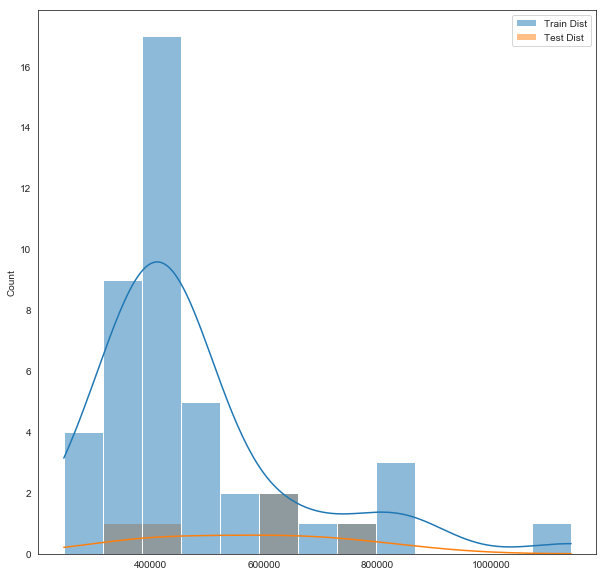

In [14]:
df = {
    'Train Dist': loglikelihoods,
    'Test Dist': test_likelihoods,
}
sns.histplot(df, kde=True)

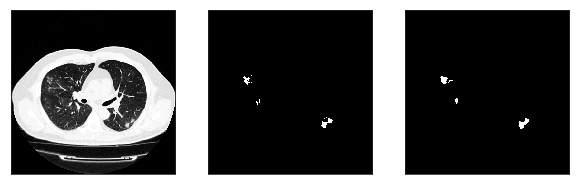

In [15]:
multiplot([
    xs[0,0].detach().cpu().numpy(),
    ys[0,0].detach().cpu().numpy(),
    ys_hat[0,0].detach().cpu().numpy(),
])

# OOD Images

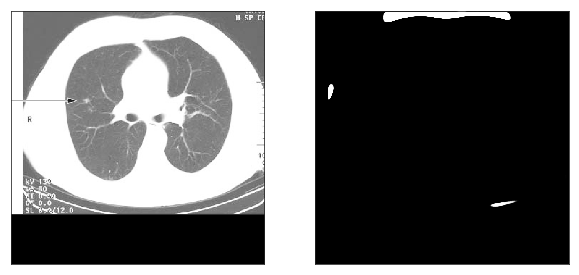

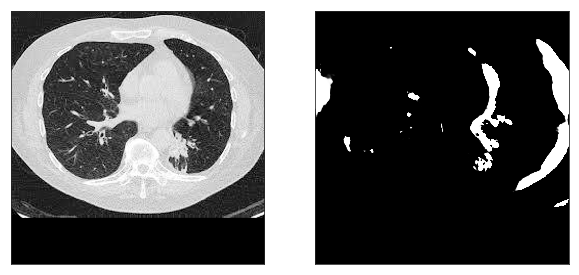

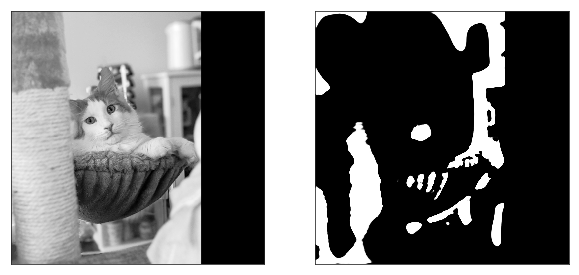

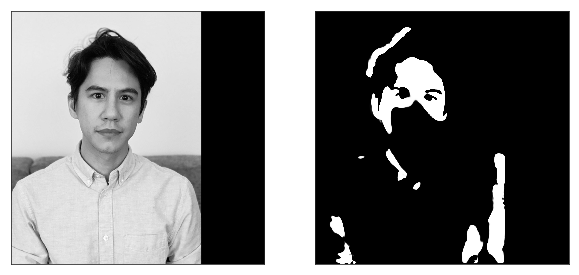

In [16]:
ood_likelihoods = []

for fpath in ood_fpaths:
    x = ImageOps.grayscale(Image.open(fpath))
    x = np.array(x)
    x = norm(pad_and_resize(x))
    x = torch.from_numpy(x[np.newaxis, np.newaxis, ...])
    x = x.float().cuda()
    
    ### segment
    y_hat = model(x)

    ### OOD detection
    y_enc = model.encode(x)[:, :, 0, 0]

    # clip parameters
    for p in flow.parameters():
        p.data = torch.clamp(p.data, clampMin, clampMax)

    # forward flow + loss
    loss, costs = compute_loss(flow, y_enc, nt=2)

    ood_likelihoods.append(loss.detach().cpu().item())
    
    multiplot([
        np.rot90(x[0,0].detach().cpu().numpy(), k=3),
        np.rot90(y_hat[0,0].detach().cpu().numpy(), k=3),
    ])

In [17]:
ood_likelihoods

[1433226.125, 201256.625, 482191.125, 314588.5]

In [20]:
loglikelihoods

[247316.625,
 356331.9375,
 332854.21875,
 465839.375,
 411191.375,
 449130.53125,
 853037.5625,
 337968.6875,
 410677.0625,
 448340.90625,
 780821.875,
 356437.4375,
 854417.3125,
 830299.5,
 449239.125,
 471632.25,
 566907.25,
 276256.15625,
 1140719.625,
 385055.375,
 354710.0625,
 482876.9375,
 372797.375,
 386254.75,
 447830.75,
 356487.625,
 285424.0625,
 353558.6875,
 435070.875,
 383272.5625,
 447430.4375,
 458284.15625,
 413694.25,
 606267.4375,
 424641.53125,
 304290.4375,
 527631.125,
 408764.25,
 438251.8125,
 413834.625,
 646071.5,
 414914.59375,
 451235.53125,
 480364.3125,
 676770.625]

In [18]:
df = {
    'Train Dist': loglikelihoods,
    'Test Dist': test_likelihoods,
    'OOD': ood_likelihoods,
}

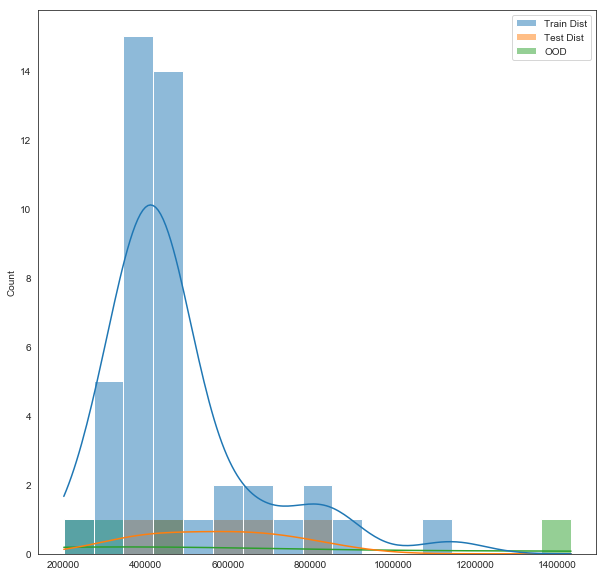

In [19]:
sns.histplot(data=df, kde=True, element='bars')